In [2]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
import os 
import json
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import torch
import recmetrics
d = torch.device('cuda:6')
dataroot = os.path.join(".","data")

## Splite training and testing data

testing school year: 499*

### User Course

In [ ]:
user_course_dense = pd.read_csv(
    os.path.join(dataroot,"course","usercoursedense.csv"),
    encoding='utf-8'
)
user_course_dense['uid'] = user_course_dense['uid'].astype(str)
user_course_dense.head()

In [4]:
user_course_dense.shape


(21829, 7055)

In [ ]:
user_course_test = user_course_dense[
    user_course_dense.uid.str.startswith('499')
]
user_course_test.head()

In [6]:
user_course_test.shape

(1254, 7055)

In [ ]:
user_course_train = user_course_dense[
    ~user_course_dense.uid.str.startswith('499')
]
user_course_train.head()

In [8]:
user_course_train.shape

(20575, 7055)

In [9]:
user_course_train.to_csv(
    os.path.join(dataroot, "course","train.csv"),
    index = False
)
user_course_test.to_csv(
    os.path.join(dataroot, "course", "test.csv"),
    index = False
)

### Book User

In [ ]:
book_user = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_userdense.csv")
)
book_user.head()

In [24]:
test_students = list(x for x in list(book_user.columns) if x[:3]=="499")
print(len(test_students))

1254


In [ ]:
book_user_test = book_user[test_students]
book_user_test.head()

In [ ]:
train_students = list(x for x in list(book_user.columns) if x[:3]!="499")
book_user_train = book_user[train_students ]
book_user_train.head()

In [30]:
book_user_train.to_csv(
    os.path.join(dataroot, "book", "cate3_train.csv"),
    index = False
)
book_user_test.to_csv(
    os.path.join(dataroot, "book", "cate3_test.csv"),
    index = False
)

#### Number of lending record for each student

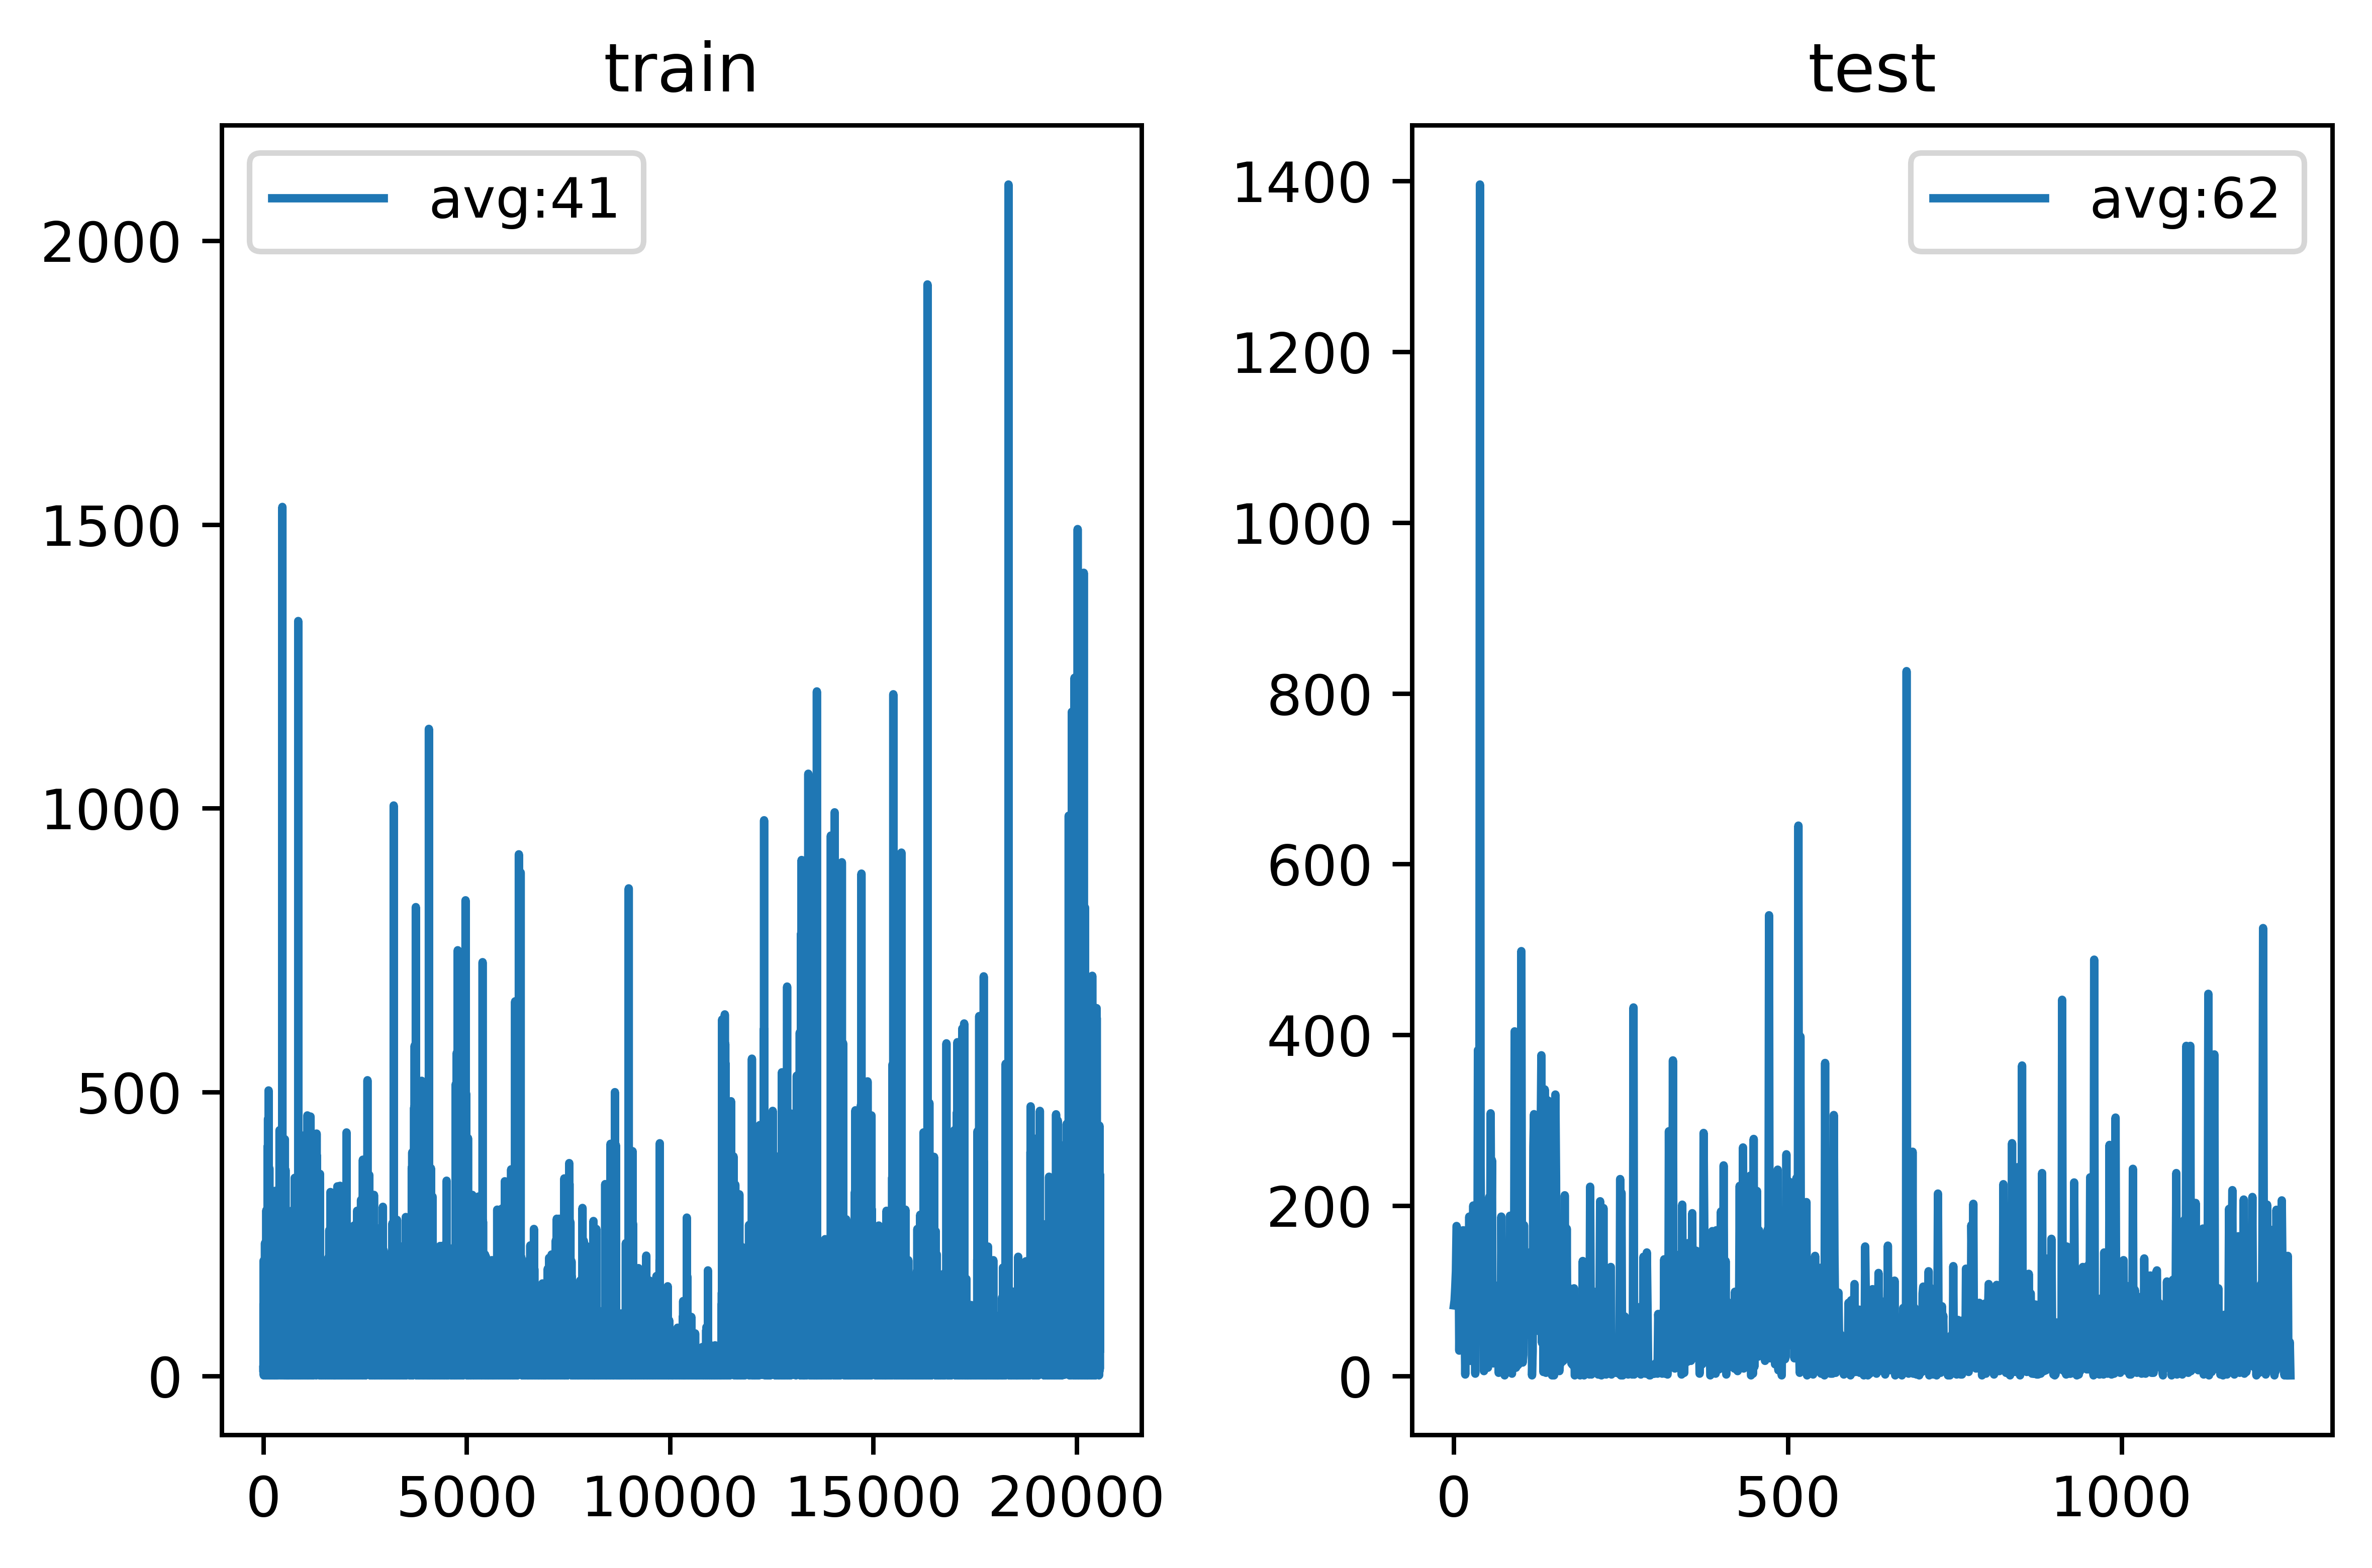

In [67]:
train_des = np.sum(book_user_train.values,axis = 0 )
test_des = np.sum(book_user_test.values, axis = 0)

fig = plt.figure(dpi=800)
plt.subplot(121)
plt.plot(
    list(i for i in range(book_user_train.shape[1])), 
    train_des, label=f"avg:{np.mean(train_des):.0f}"
)
plt.legend()
plt.title("train")

plt.subplot(122)
plt.plot(
    list(i for i in range(book_user_test.shape[1])), 
    test_des,label=f"avg:{np.mean(test_des):.0f}"
)
plt.legend()
plt.title("test")

plt.tight_layout()
plt.savefig(os.path.join(dataroot,"book","train_test_count.jpg"))


## Recommend

### METHOD1
Using all courses that a user have had taken.  



In [45]:
method1_savepath = os.path.join("result", "CF", "samecourse")
if not os.path.exists(method1_savepath):
    print(f"mkdir : {method1_savepath}")
    os.mkdir(method1_savepath)

#### Construct CF matrix
 
$$M_{\text{book}\times\text{train users}} \times M_{\text{train users}\times\text{course}}$$

In [7]:
user_course_train = pd.read_csv(
    os.path.join(dataroot, "course","train.csv")
)
user_course_train['uid'] = user_course_train['uid'].astype(str)
print("train user course OK")


book_user_train = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_train.csv")
)
print("train book user Ok")

train user course OK
train book user Ok


In [11]:
book_user_train_tensor = torch.tensor(
    book_user_train.values
)
print(book_user_train_tensor.size())

torch.Size([1000, 20575])


In [8]:
user_course_train_tensor = torch.tensor(
    (user_course_train.drop(columns=['uid'])).values
)
print(user_course_train_tensor.size())



torch.Size([1000, 20575])
torch.Size([20575, 7054])


In [227]:
book_course_tensor = torch.matmul(
    book_user_train_tensor.to(device=d),
    user_course_train_tensor.to(device=d)
).cpu()

print(book_course_tensor.size())


torch.Size([1000, 7054])


##### Write result for 3 type of file
torch tensor, numpy array, csv

In [233]:
torch.save(
    book_course_tensor, 
    os.path.join(method1_savepath,"cf_book_course.pt")
)

In [228]:
book_course_matrix = book_course_tensor.numpy()

In [229]:
np.save(
    os.path.join(method1_savepath,"cf_book_course"),
    book_course_matrix
)

In [ ]:
book_course_df = pd.DataFrame(
    columns=user_course_train.drop(columns=['uid']).columns,
    data=book_course_matrix
)
print(book_course_df.shape)
book_course_df.head()

In [10]:
book_course_df.to_csv(
    os.path.join(method1_savepath,"cf_book_course.csv"),
    index = False
)

#### Generate recommend list

In [14]:
user_course_test = pd.read_csv(
    os.path.join(dataroot, "course", "test.csv")
)
user_course_test['uid'] = user_course_test['uid'].astype(str)
print("test user course OK")

user_course_test_matrix = (
    user_course_test.drop(columns = ['uid'])
).values



test user course OK


##### Read the collaborative tabel 
$M_{\text{book}\times \text{course}}$

In [3]:
# If continuous executing this Note book from 
# the H1 label "Recommend"
# ,there is no needed to execute this cell

book_course_tensor= torch.load(
    os.path.join(method1_savepath,"cf_book_course.pt")
)
book_course_tensor.size()

torch.Size([1000, 7054])

##### Generate top N list
Find the top N number of each prefix 3 book categories that counted from the other studensts who have had the same courses with the test student.

In [6]:
recommend_list = {}
for i in tqdm(range(user_course_test.shape[0])):
    uid = user_course_test.iloc[i]['uid']
    testi = user_course_test_matrix[i][:]
    itscourses = np.where(testi>0)
    cf = torch.sum(book_course_tensor[:, itscourses[0]],dim=1)
    ordered = torch.argsort(cf,descending=True)
    recommend_list[uid] = ordered.tolist()

100%|██████████| 1254/1254 [00:05<00:00, 218.42it/s]


In [7]:
with open(os.path.join(method1_savepath,"recommend_list.json"),"w+") as rl:
    json.dump(recommend_list, rl, indent=4)


### METHOD2 
Using top N similarity users according to  course selection to recommend.

In [3]:
method2_savepath = os.path.join("result", "CF", "simuser")
if not os.path.exists(method2_savepath):
    print(f"mkdir : {method2_savepath}")
    os.mkdir(method2_savepath)

In [4]:
user_course_train = pd.read_csv(
    os.path.join(dataroot, "course","train.csv")
)
print("training course read OK")
trainuid = user_course_train.uid.tolist()
user_course_train_tensor = torch.tensor(
    (user_course_train.drop(columns=['uid'])).values
)

user_course_test = pd.read_csv(
    os.path.join(dataroot, "course","test.csv")
)
print("testing course read OK")
testuid = user_course_test.uid.tolist()
user_course_test_tensor = torch.tensor(
    (user_course_test.drop(columns=['uid'])).values
)

training course read OK
testing course read OK


#### Pairwise cosine similarity

In [ ]:
user_course_train_tensor = user_course_train_tensor.to(device=d)
user_course_test_tensor = user_course_test_tensor.to(device=d)


In [ ]:
testing_user = {}
for i in testuid:
    testing_user[i] = []

for i in tqdm(range(user_course_test_tensor.size()[0])):
    pairwise_sim = torch.cosine_similarity(
        user_course_test_tensor[i], user_course_train_tensor
    )
    ordered = torch.argsort(pairwise_sim,descending=True).cpu().tolist()
    for simu in ordered:
        testing_user[testuid[i]].append(trainuid[simu])

    

100%|██████████| 1254/1254 [01:33<00:00, 13.37it/s]


In [ ]:
with open(os.path.join(method2_savepath,"simuser.json"), "w+") as jf:
    json.dump(testing_user, jf, indent=4, ensure_ascii=False)

#### Get most top N similarity users for each test user
Get most top N similarity users for each test user and recommend that test user the category what similarity users had read.

In [5]:
book_user_train = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_train.csv")
)

In [6]:
# If continuously execution from the beginning of
# pairwise cosine similarity, 
# no need to execution this block. 
# Using the result that generate from above block.

testing_user = {}
with open(os.path.join(method2_savepath,"simuser.json"), "r") as jf:
    testing_user = json.load(jf)

In [7]:
recommend_list = {}
for testuser in testuid:
    recommend_list[testuser]=[]

In [8]:
for topN in tqdm(range(1, 101)):
    for u in testuid:
        simstudents = list(map(lambda x:str(x), testing_user[str(u)][:topN]))
        test_topN = book_user_train[simstudents]
        rl = np.sum(test_topN.values, axis=1)
        o = np.argsort(-rl)
        suggest = list(int(c) for c in o.tolist())
        recommend_list[u].append(suggest)


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


In [9]:
with open(os.path.join(method2_savepath, "recommend_list.json"), "w+") as jf:
    json.dump(recommend_list, jf, indent=4, ensure_ascii=False)
